In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
#read in each song from each mood folder, create mel-spectrogram, and save as png in same folder
happy_df = pd.DataFrame()
sad_df = pd.DataFrame()
nrg_df = pd.DataFrame()
calm_df = pd.DataFrame()

# Load the audio file
moods = ['happy','sad','energetic'] #,'calm'
for mood in moods:
    pngs = []
    path_of_the_directory= 'mp3s/'+mood
    print("PNGs in "+mood+" folder:")
    for filename in os.listdir(path_of_the_directory):
        f = os.path.join(path_of_the_directory,filename)
        try:
            if (os.path.isfile(f)) & ('.png' in filename):
                pngs.append(filename)
        except Exception:
            pass
    if mood == 'happy':
        happy_df['images'] = pngs
        happy_df['label'] = np.zeros(len(pngs),dtype=int)
    if mood == 'sad':
        sad_df['images'] = pngs
        sad_df['label'] = np.ones(len(pngs),dtype=int)
    if mood == 'energetic':
        nrg_df['images'] = pngs
        nrg_df['label'] = np.ones(len(pngs),dtype=int)
        nrg_df['label'] +=1
    if mood == 'calm':
        calm_df['images'] = pngs
        calm_df['label'] = np.ones(len(pngs),dtype=int)
        calm_df['label'] +=2

PNGs in happy folder:
PNGs in sad folder:
PNGs in energetic folder:


In [3]:
happy_df
sad_df
nrg_df
# calm_df

,images,label
0,Do It To It.mp3.png,2
1,Watch Out (feat. Drizzin) - Radio Edit.mp3.png,2
2,Moonrise.mp3.png,2
3,Say So.mp3.png,2
4,You Belong With Me (Taylor’s Version).mp3.png,2
...,...,...
369,Sundara - Instrumental.mp3.png,2
370,Dusty.mp3.png,2
371,Time.mp3.png,2
372,Naya.mp3.png,2


In [4]:
from sklearn.model_selection import train_test_split
#randomly sample 325 songs from each
df = pd.concat([happy_df.sample(n=325, random_state=1), sad_df.sample(n=325, random_state=1), nrg_df.sample(n=325, random_state=1)])
#create train and test split
df_train, df_test = train_test_split(df, test_size=0.23) #0.23 gets exactly 500 of the 650 which is a nice number

In [5]:
df_train
df_test

,images,label
238,Always.mp3.png,2
282,Without Me.mp3.png,2
179,The Other Side.mp3.png,2
272,7th Sevens.mp3.png,2
178,Que Me Hiciste.mp3.png,1
...,...,...
104,chance with you.mp3.png,1
63,yashinoki.mp3.png,2
205,Jennesys.mp3.png,2
238,heartbreak honeymoon.mp3.png,1


In [6]:
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

img_size = 256
X = []
for i,mood in enumerate(moods):
  path = 'mp3s/'+mood
  for filename in tqdm(os.listdir(path)):
    if filename in df_train[df_train['label'] == i]['images'].values:
      img = image.load_img(path+'/'+filename, target_size=(img_size, img_size, 3))
      img = image.img_to_array(img).astype('float32')
      X.append(img)
X = np.array(X)
X.shape

100%|██████████| 374/374 [00:02<00:00, 150.39it/s]


(750, 256, 256, 3)

In [7]:
y = np.array(df_train['label'].reset_index(drop=True))
y.shape

(750,)

In [8]:
X_test = []
for i,mood in enumerate(moods):
  path = 'mp3s/'+mood
  for filename in tqdm(os.listdir(path)):
    if filename in df_test[df_test['label'] == i]['images'].values:
      img = image.load_img(path+'/'+filename, target_size=(img_size, img_size, 3))
      img = image.img_to_array(img).astype('float32')
      X_test.append(img)
X_test = np.array(X_test)
X_test.shape

100%|██████████| 374/374 [00:00<00:00, 398.49it/s]


(225, 256, 256, 3)

In [9]:
y_test = np.array(df_test['label'].reset_index(drop=True))
y_test.shape

(225,)

In [32]:
X /= 255
X_test /= 255

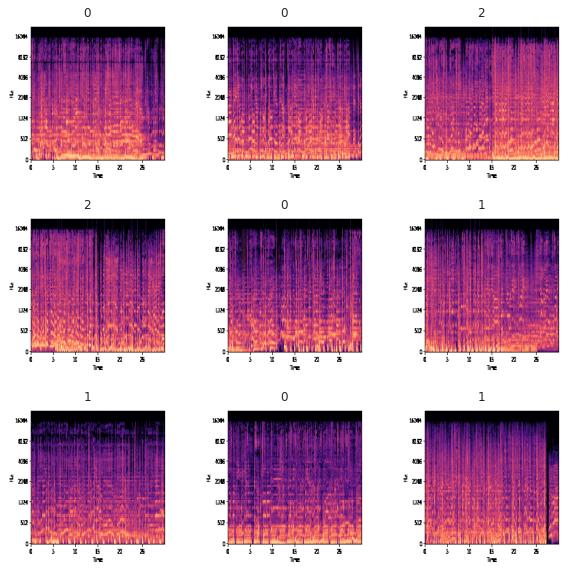

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.array_to_img(X[i]))
    plt.title(int(y[i]))
    plt.axis("off")

In [34]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Reset Model
tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(img_size,img_size,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(128, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

In [35]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mae'])

In [36]:
ne = 100
history = model.fit(X,y,epochs=ne, verbose=1, validation_data = (X_test, y_test))

Epoch 1/100
24/24 [==============================] - 3s 102ms/step - loss: 1.1517 - accuracy: 0.3093 - mae: 0.8800 - val_loss: 1.0987 - val_accuracy: 0.3244 - val_mae: 0.9185
Epoch 2/100
24/24 [==============================] - 2s 85ms/step - loss: 1.1007 - accuracy: 0.3347 - mae: 0.8800 - val_loss: 1.0992 - val_accuracy: 0.3156 - val_mae: 0.9185
Epoch 3/100
24/24 [==============================] - 2s 85ms/step - loss: 1.0988 - accuracy: 0.3160 - mae: 0.8800 - val_loss: 1.0992 - val_accuracy: 0.3244 - val_mae: 0.9185
Epoch 4/100
24/24 [==============================] - 2s 84ms/step - loss: 1.0987 - accuracy: 0.3413 - mae: 0.8800 - val_loss: 1.0986 - val_accuracy: 0.3156 - val_mae: 0.9185
Epoch 5/100
24/24 [==============================] - 2s 84ms/step - loss: 1.1002 - accuracy: 0.3187 - mae: 0.8800 - val_loss: 1.0990 - val_accuracy: 0.3156 - val_mae: 0.9185
Epoch 6/100
24/24 [==============================] - 2s 85ms/step - loss: 1.0989 - accuracy: 0.3547 - mae: 0.8800 - val_loss: 1.0

KeyboardInterrupt: ignored

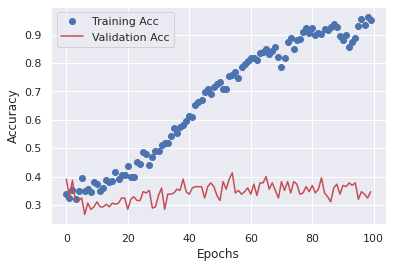

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hd = history.history

loss_tr = hd['accuracy']
loss_va = hd['val_accuracy']
epochs = range(0, ne) #ne is number of epochs. Set it! 

plt.plot(epochs, loss_tr, 'o', label='Training Acc')
plt.plot(epochs, loss_va, 'r', label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Reset Model
tf.keras.backend.clear_session()

In [17]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(img_size, img_size, 3))
conv_base.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [18]:
inputs = keras.Input(shape=(img_size, img_size, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                             

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_model.keras",
        save_best_only=True,
        monitor="accuracy")
]

history = model.fit(X,y,epochs=100,batch_size=128,verbose=1,callbacks=callbacks,validation_data = (X_test, y_test))

Epoch 1/100
6/6 [==============================] - 36s 4s/step - loss: 1.0970 - accuracy: 0.3400 - val_loss: 1.1000 - val_accuracy: 0.3156
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 1.0955 - accuracy: 0.3413 - val_loss: 1.1000 - val_accuracy: 0.3156
Epoch 3/100
6/6 [==============================] - 8s 1s/step - loss: 1.0970 - accuracy: 0.3400 - val_loss: 1.1000 - val_accuracy: 0.3156
Epoch 4/100
6/6 [==============================] - 8s 1s/step - loss: 1.0970 - accuracy: 0.3400 - val_loss: 1.0999 - val_accuracy: 0.3156
Epoch 5/100
6/6 [==============================] - 8s 1s/step - loss: 1.0970 - accuracy: 0.3400 - val_loss: 1.0999 - val_accuracy: 0.3156
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 1.0955 - accuracy: 0.3413

KeyboardInterrupt: ignored

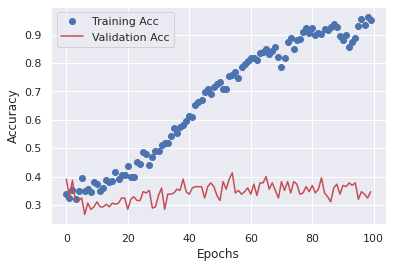

In [24]:
hd = history.history

loss_tr = hd['accuracy']
loss_va = hd['val_accuracy']
epochs = range(0, 100)

plt.plot(epochs, loss_tr, 'o', label='Training Acc')
plt.plot(epochs, loss_va, 'r', label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
model.predict(X_test)

array([[0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.3028042 , 0.3354591 , 0.3617367 ],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.33072963, 0.34305212, 0.32621825],
       [0.

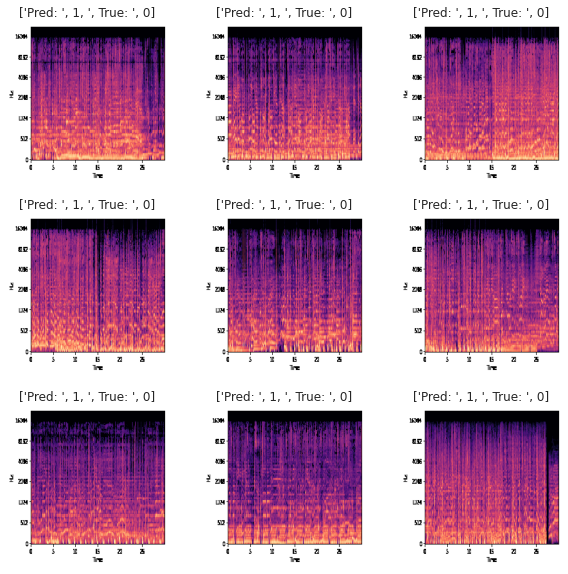

In [25]:
y0 = model.predict(X)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.array_to_img(X[i]))
    predClass = np.argmax(y0[i], axis=-1)
    trueClass = np.argmax(y[i], axis=-1)
    plt.title(["Pred: ", int(predClass), ", True: ", int(trueClass)])
    plt.axis("off")